In [1]:
import pandas as pd
import numpy as np
# import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

import seaborn as sns



from session_config import bin_labels, feature_variables, collect_survey_data
# import reports
from userdisplay import most_common, table_css_styles, highlight_max, format_kwargs
# import geospatial
from gridforecast import make_report_objects, reports_and_forecast, forecast_weighted_prior
# import datetime as dt
from IPython.display import Markdown

# import shap

from featureevaluator import FeatureEvaluation

In [2]:
data = collect_survey_data()

# from use_cases example
ooi = ['G10',  'Gcaps', 'G30', 'G31', 'G33', 'G34', 'G35', 'G8', 'G7', 'G6', 'G5', 'G4', 'G37', 'G2', 'G27', 'G25']

# more refined search
tobo_snacks = ['G27', 'G30', 'G35']

# unidentified, plastic, different uses
udi = ['Gfrags', 'Gfoams']

# industrial
indus = ['G89', 'G67', 'G112', 'G93' , 'G66' 'G74', 'G72', 'Gfrags', 'Gfoams']

o_dates = {'start':'2020-01-01', 'end':'2021-12-31'}
prior_dates = {'start':'2015-11-15', 'end':'2019-12-31'}
# (d['date'] >= o_dates['start'])&
# all data
canton = 'Vaud'
land_covers = ['buildings', 'forest', 'undefined', 'public services', 'streets']
d= data.reset_index(drop=True)


# make complete report
params_l = {'canton':canton, 'date_range':o_dates, 'feature_type': 'l'}
params_p = {'canton':canton, 'date_range':prior_dates, 'feature_type':'l'}

# set the parameters for the weighted prior
# exclude records in the likelihood, set date range and feature type
# make the land-use-inventory, exclude any likelihood values
lu_catalogue = d[(d.canton != canton)&(d['date'] <= o_dates['end'])&(d.feature_type == 'l')].copy()
lu_catalogue = lu_catalogue[lu_catalogue.code.isin(tobo_snacks)].copy()
catalog_surveys, catalog_features = make_report_objects(lu_catalogue)

newd = catalog_features.df_cat.copy()
newd['feature_type'] = 'l'


# make the data for a likelihood and prior
data_of_interest = d[(d.canton == canton)&(d.feature_type == 'l')].copy()
data_of_interest = data_of_interest[data_of_interest.code.isin(tobo_snacks)].copy()
data_of_interest.reset_index(inplace=True)

args = {
    'likelihood': params_l,
    'prior' : params_p,
    'data' : data_of_interest,
    'land-use-inventory' : newd.copy(),
}

results = reports_and_forecast(args['likelihood' ], args['prior'], ldata=args['data'], other_data=args['land-use-inventory'])

feature_data = pd.concat([results['this_land_use'].df_cont, results['prior_land_use'].df_cont])
feature_data.reset_index(inplace=True, drop=True)

feature_evaluator = FeatureEvaluation(feature_data)
results

{'this_report': <reports.SurveyReport at 0x7c1df2c88610>,
 'this_land_use': <geospatial.LandUseReport at 0x7c1df2c88e80>,
 'prior_report': <reports.SurveyReport at 0x7c1df2c29af0>,
 'prior_land_use': <geospatial.LandUseReport at 0x7c1df2c29e80>,
 'posterior_no_limit': <gridforecast.MulitnomialDirichlet at 0x7c1df2c3a580>,
 'posterior_99': <gridforecast.MulitnomialDirichlet at 0x7c1df2c3a730>,
 'comments': ' ok okok'}

In [3]:

# highlight_props = 'background-color:#FAE8E8'
# def highlight_max(s, arg, props: str = highlight_props):
#     return np.where((s > arg) & (s != 0), props, '')

def admin_report(data, admin_boundary):
    d = data.groupby(admin_boundary).agg({'pcs/m':'mean', 'quantity':'sum', 'sample_id':'count'})
    return d

def features_present(data, a_feature_inventory):
    feature_types = a_feature_inventory.gt(0).apply(lambda x: x.index[x].tolist(), axis=1)
    
    feature_types = [x[0] for x in feature_types]

    summardata = data.groupby(['sample_id', 'feature_type','feature_name'], as_index=False).agg({'pcs/m':'sum'})
    
    feature_individual_summary = summardata.groupby(['feature_type','feature_name'], as_index=False).agg({'sample_id':'nunique', 'pcs/m':'mean'})
    results = {}
    for features in feature_types:
        
        d = feature_individual_summary[feature_individual_summary.feature_type == features[0]].copy()
        results[features] = d
    
    return results


def histograms_standard(data):   

    fig, ax = plt.subplots()
    
    for some_data in data:
        sns.histplot(data=some_data[0], x='pcs/m', stat='probability', label=some_data[1], ax=ax, color=some_data[2])
    ax.legend()
    plt.tight_layout()
    
    plt.close()

    return fig

def ecdf_plots_standard(data):

    fig, ax = plt.subplots()

    for some_data in data:
        print(some_data[1], some_data[3])
        sns.ecdfplot(some_data[0], label=some_data[1], ls=some_data[2], ax=ax, c=some_data[3], zorder=1)

    ax.set_xlim(-.1, results['this_report'].sample_results['pcs/m'].quantile(.99))
    ax.legend()
    plt.tight_layout()
    plt.close()
    return fig




title = f'All samples {canton}: {prior_dates["start"]} - {o_dates["end"]}'
def scatter_plot_standard(data):

    fig, ax = plt.subplots()   
    
    # locate the ticks
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m"))
    
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%Y"))

    for some_data in data:
        sns.scatterplot(data=some_data[0], x='date', y='pcs/m', marker='x', label=some_data[1], ax=ax, color=some_data[2])
    
    ax.legend()
    ax.set_xlabel('')
    plt.tight_layout()
    plt.close()

    return fig


def labels_for_display(args):
    start = args['date_range']['start'][:4]
    end = args['date_range']['end'][:4]
    labels = f"{start} - {end}"
    return labels

color_style = {'prior':'color: #daa520', 'likelihood':'color: #1e90ff'}
palette = {'prior':'goldenrod', 'likelihood':'dodgerblue'}

def make_standard_report(results, args):

    # data for plots
    observedvals = []
    forecasts = []

    display_results = [ 
        'weighted-forecast', 
        'observed-max-forecast',
        'observed-99-forecast',
        'proportion-most-common',
        'most-common-objects',
        'sampling-summary',
        'prior-sampling-summary',
        'observed-values',
        'forecasted-values',
        'likelihood-labels',
        'prior-labels']

    display_r = {x: 'No data' for x in display_results}    
    
    # make the labels for display
    likelihood_labels = labels_for_display(args['likelihood'])
    prior_labels = labels_for_display(args['prior'])

    l_summary = results['this_report'].sampling_results_summary.copy()
    
    # most common objects the likelihood data
    object_inventory = results['this_report'].object_summary()
    object_inventory.reset_index(drop=False, inplace=True)
    most_common_objects, mc_codes, proportions = most_common(object_inventory)
    most_common_objects = most_common_objects.set_caption("")
    ratio_most_common = Markdown(f'__The most common objects account for {int(proportions*100)}% of all objects__')

    observedvals.append((results['this_report'].sample_results[['pcs/m']], likelihood_labels, palette['likelihood']))

    weighted_args = [
        results['this_land_use'].n_samples_per_feature(), 
        args['land-use-inventory'],
        bin_labels,
        feature_variables,
        results['this_report'].sample_results['pcs/m']
    ]
    weighted_forecast, weighted_posterior, weighted_summary, selectedr = forecast_weighted_prior(*weighted_args)
    
    forecasts.append((weighted_forecast, 'weighted prior', '-.', 'black'))
    forecasts.append((results['this_report'].sample_results[['pcs/m']], likelihood_labels, '-',palette['likelihood']))
    
    display_r.update({
        'proportion-most-common' : ratio_most_common,
        'most-common-objects' : most_common_objects,
        'sampling-summary' : l_summary,
        'likelihood-labels': likelihood_labels,
        'weighted-forecast': weighted_summary})
    
    if results['prior_report'] == 'No prior':
           
        # make the display text
        header = f"<font color=#daa520>{prior_labels}</font>"
        info = '* No data for the period requested\n'
        sampling_summary = Markdown(f'{header}\n{info}')
        forecast_maxval =  Markdown('__Given the observed max__\n* No prior data to consider see weighted prior\n')
        forecast_99 = Markdown('__Given the observed 99__\n* No prior data to consider see weighted prior\n')
        
                
        # update display object
        display_r.update({
            'prior-sampling-summary' : sampling_summary,
            'prior-labels': prior_labels,
            'observed-max-forecast': forecast_maxval,
            'observed-99-forecast' : forecast_99
        })

    else:

        p_summary = results['prior_report'].sampling_results_summary
        

        observedvals.append((results['prior_report'].sample_results[['pcs/m']], prior_labels, palette['prior']))
        forecasts.append((results['prior_report'].sample_results[['pcs/m']], prior_labels, ':',palette['prior']))

        forecast_maxval = results['posterior_no_limit'].get_descriptive_statistics()        
        forecast_99 = results['posterior_99'].get_descriptive_statistics()
        
        forecasts.append((results['posterior_99'].posterior_samples, 'expected 99th', '-', 'blue'))
        forecasts.append((results['posterior_no_limit'].posterior_samples, 'observed max', ':', 'red'))
        
        display_r.update({
            'prior-sampling-summary' : p_summary,
            'prior-labels': prior_labels,
            'observed-max-forecast': forecast_maxval,
            'observed-99-forecast' : forecast_99,
            'observed-values': observedvals,
            'forecasted-values': forecasts
            
        })

    return display_r

standard = make_standard_report(results, args)

In [4]:
standard['likelihood-labels']

'2020 - 2021'

In [5]:
standard['prior-labels']

'2015 - 2019'

In [6]:
a_report = results['this_report']
land_use = results['this_land_use']

In [7]:
a_report.administrative_boundaries()

,location,city,canton,parent_boundary
count,22,13,1,2


In [8]:
a_report.feature_inventory()

,river,lake,park
count,0,2,0


In [9]:
a_report.material_report

material,plastic
% of total,100%


In [10]:
standard['sampling-summary']

,total,nsamples,average,5th,25th,50th,75th,95th,std,max,start,end
0,3720,85,1.249765,0.072,0.33,0.84,1.57,4.136,1.407314,8.0,2020-04-28,2021-10-07


In [11]:
standard['prior-sampling-summary']

,total,nsamples,average,5th,25th,50th,75th,95th,std,max,start,end
0,13706,141,2.421418,0.09,0.4,1.37,3.0,8.6,3.435479,23.62,2015-11-23,2019-10-24


Survey total pcs/m 2020 - 2021 versus 2015 - 2019. All locations considered.


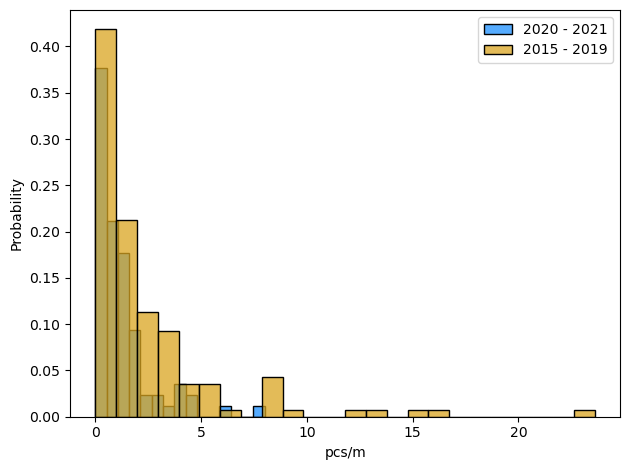

In [12]:

caption_histo = f"Survey total pcs/m {standard['likelihood-labels']} versus {standard['prior-labels']}. All locations considered."
print(caption_histo)
histograms_standard(standard['observed-values'])

All samples Vaud: 2015-11-15 - 2021-12-31


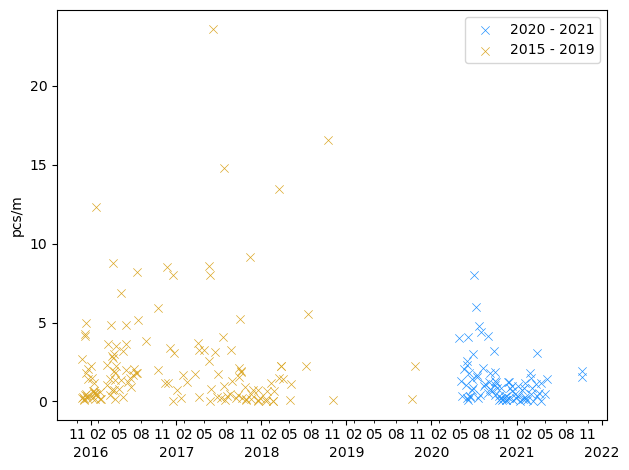

In [13]:
data = [
    (results['this_report'].sample_results, standard['likelihood-labels'], palette['likelihood']),
    (results['prior_report'].sample_results, standard['prior-labels'], palette['prior'])
]

title = f'All samples {canton}: {prior_dates["start"]} - {o_dates["end"]}'
print(title)
scatter_plot_standard(data)

In [14]:
standard['proportion-most-common']

__The most common objects account for 100% of all objects__

In [15]:
standard['most-common-objects']

Object,Quantity,pcs/m,% of total,Fail rate
Cigarette filters,2'410,"0,84","0,65","0,94"
"Food wrappers; candy, snacks",1'123,"0,35","0,30","0,95"
Straws and stirrers,187,"0,06","0,05","0,69"


In [16]:

land_use.n_samples_per_feature()

,orchards,vineyards,buildings,forest,undefined,public services,streets
1,85,83,5,83,62,71,8
2,0,0,5,2,16,14,66
3,0,2,1,0,6,0,11
4,0,0,32,0,1,0,0
5,0,0,42,0,0,0,0


In [17]:
land_use.rate_per_feature()

,orchards,vineyards,buildings,forest,undefined,public services,streets
1,1.249765,1.267831,0.782,1.273614,1.542419,1.071408,0.87625
2,0,0,0.318,0.26,0.3925,2.154286,1.122424
3,0,0.5,2.06,0,0.706667,0,2.285455
4,0,0,0.986875,0,0.08,0,0
5,0,0,1.597381,0,0,0,0


In [18]:
standard['observed-max-forecast']

,code,average,hdi min,hdi max,5th,25th,50th,75th,95th,max_observed
0,max value,2.8396,0.0,16.89,0.0695,0.3275,1.14,2.73,15.4555,23.62


In [19]:
standard['observed-99-forecast']

,code,average,hdi min,hdi max,5th,25th,50th,75th,95th,max_observed
0,99th percentile,3.4972,0.0,19.74,0.0,0.38,1.32,3.695,17.3935,23.62


weighted prior black
2020 - 2021 dodgerblue
2015 - 2019 goldenrod
expected 99th blue
observed max red


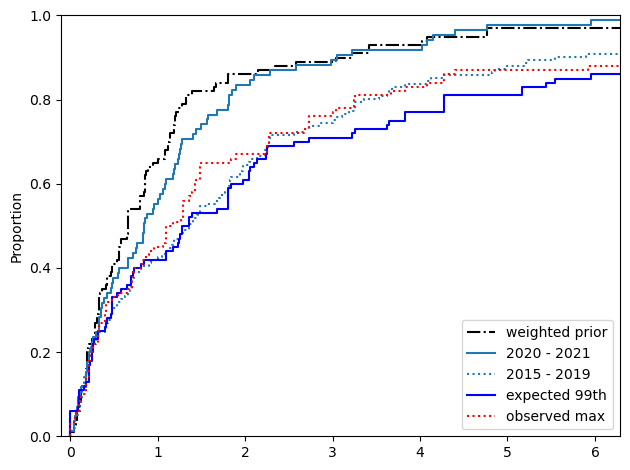

In [20]:
data = standard['forecasted-values']

ecdf_plots_standard(data)

In [21]:
standard['weighted-forecast']

,code,average,hdi min,hdi max,5th,25th,50th,75th,95th,max_observed
0,weighted prior,1.2724,0.03,5.01,0.089,0.21,0.485,1.6,4.934,10.37


In [22]:
dxl = a_report.df
# dxf = land_use.df_cont

admin_report(dxl, 'city')

,pcs/m,quantity,sample_id
city,,,
Allaman,0.376667,113,9
Bourg-en-Lavaux,0.166667,12,6
Cudrefin,0.026667,1,3
Gland,0.086667,25,6
Grandson,0.110000,23,3
La Tour-de-Peilz,0.251556,541,45
Lausanne,0.938571,160,21
Montreux,0.406667,192,21
Préverenges,0.490769,809,39


In [23]:
# feature report
a_feature_inventory = a_report.feature_inventory()
data =  a_report.df
feature_report = features_present(data, a_feature_inventory)
feature_report['lake']

,feature_type,feature_name,sample_id,pcs/m
0,l,lac-leman,70,1.454714
1,l,neuenburgersee,15,0.293333


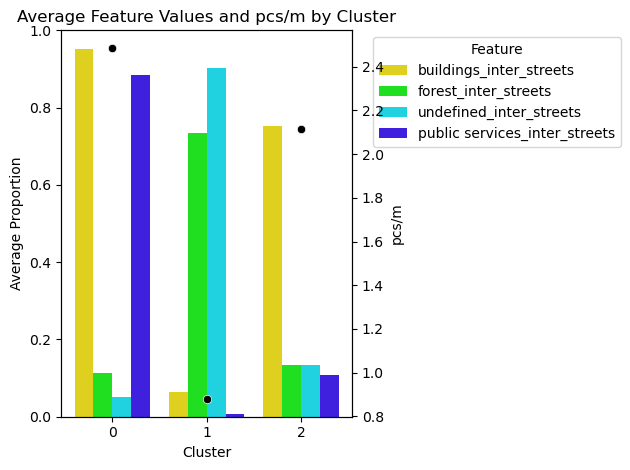

In [24]:
n = feature_evaluator.determine_optimal_clusters()

cluster_summaryi, clusters, dx= feature_evaluator.kmeans_clustering(n, w_interactions =True)
cluster_summaryi.set_index('clusters', inplace=True, drop=True)
feature_evaluator.plot_cluster_barchart(cluster_summaryi, "hello",w_interactions = True)

In [25]:
cluster_summaryi.style.set_table_styles(table_css_styles).apply(highlight_max, axis=0).format(**format_kwargs)

,samples,pcs/m,buildings_inter_streets,forest_inter_streets,undefined_inter_streets,public services_inter_streets
clusters,,,,,,
0,34,"2,49","0,95","0,04","0,04","0,33"
1,35,"0,88","0,11","0,26","0,58","0,00"
2,157,"2,12","0,76","0,05","0,09","0,04"


In [26]:
regression_results, best_model, the_name, X_test, y_test, X_train, y_train = feature_evaluator.perform_regression_analysis(w_interactions =True)
pd.DataFrame(regression_results).style.set_table_styles(table_css_styles).apply(highlight_max, axis=0).format(**format_kwargs)

,Model,R²,MSE
0,Linear Regression,"0,03","0,03"
1,Random Forest Regression,"0,14","0,02"


In [27]:
g = best_model.predict(X_test)
g = pd.DataFrame(g)
predictions = feature_evaluator.target_scaler.inverse_transform(g).flatten()
np.mean(predictions)

1.8172944718610966

In [28]:
model_feature_importance, permutation_feature_importance = feature_evaluator.evaluate_feature_importance( best_model, the_name, X_test, y_test, X_train, y_train)
model_feature_importance.style.set_table_styles(table_css_styles).format(**format_kwargs)

,Feature,Importance
2,undefined_inter_streets,"0,48"
0,buildings_inter_streets,"0,30"
3,public services_inter_streets,"0,13"
1,forest_inter_streets,"0,09"


In [29]:
permutation_feature_importance.style.set_table_styles(table_css_styles).format(**format_kwargs)

,Feature,Importance
0,buildings_inter_streets,"0,17"
2,undefined_inter_streets,"0,09"
3,public services_inter_streets,"-0,01"
1,forest_inter_streets,"-0,01"


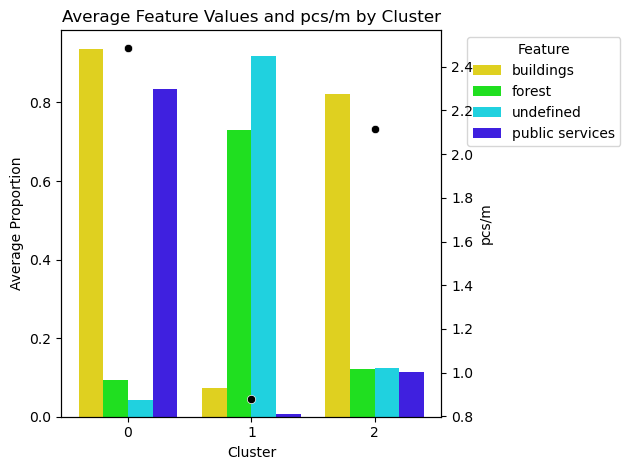

In [30]:
cluster_summary, clusters, dx= feature_evaluator.kmeans_clustering(n, w_interactions = False)
cluster_summary.set_index('clusters', inplace=True, drop=True)
feature_evaluator.plot_cluster_barchart(cluster_summary, "hello",w_interactions = False)

In [31]:
cluster_summary.style.set_table_styles(table_css_styles).apply(highlight_max, axis=0).format(**format_kwargs)

,samples,pcs/m,buildings,forest,undefined,public services
clusters,,,,,,
0,34,"2,49","0,94","0,03","0,03","0,31"
1,35,"0,88","0,12","0,26","0,59","0,00"
2,157,"2,12","0,83","0,04","0,08","0,04"


In [32]:
regression_results, best_model, the_name, X_test, y_test, X_train, y_train = feature_evaluator.perform_regression_analysis(w_interactions =False)
pd.DataFrame(regression_results).style.set_table_styles(table_css_styles).apply(highlight_max, axis=0).format(**format_kwargs)

,Model,R²,MSE
0,Linear Regression,"0,03","0,03"
1,Random Forest Regression,"0,14","0,02"


In [33]:
g = best_model.predict(X_test)
g = pd.DataFrame(g)
predictions = feature_evaluator.target_scaler.inverse_transform(g).flatten()
np.mean(predictions)

1.832266897726294

In [34]:
model_feature_importance, permutation_feature_importance = feature_evaluator.evaluate_feature_importance( best_model, the_name, X_test, y_test, X_train, y_train)
model_feature_importance.style.set_table_styles(table_css_styles).format(**format_kwargs)

,Feature,Importance
3,undefined,"0,32"
0,streets,"0,28"
1,buildings,"0,25"
4,public services,"0,11"
2,forest,"0,04"


In [35]:
permutation_feature_importance.style.set_table_styles(table_css_styles).format(**format_kwargs)

,Feature,Importance
3,undefined,"0,07"
1,buildings,"0,06"
0,streets,"0,06"
4,public services,"0,00"
2,forest,"-0,00"


# Report on Litter Analysis in the Canton of Bern, Switzerland

## Abstract

This report investigates the distribution and determinants of litter, specifically cigarette ends, snack wrappers, drink straws, and coffee stirrers, along the shores of lakes in the Canton of Bern, Switzerland. The study aims to identify areas that would benefit most from investment in reducing plastic waste, using topographical features as key determinants. Using regression analysis, cluster analysis, and Bayesian methods, we determine the areas with the greatest need and the factors most correlated with litter presence.

## Introduction

The accumulation of litter in natural environments poses significant ecological and aesthetic challenges. This study focuses on the litter found on the shores of lakes in the Canton of Bern, Switzerland. Our objective is to identify the areas most in need of intervention to reduce plastic and other trash. We examine the relationships between various land use features and the density of litter to prioritize areas for investment. 

## Methods

Data collection followed the protocol outlined in "A guide for monitoring litter on European seas" and involved volunteers sampling pieces of trash per meter (pcs/m). The dataset includes land use features within a 1,500-meter buffer zone around the lakes. We conducted cluster and regression analyses, both with and without interaction terms, and utilized a Bayesian approach to predict future trends.

## Results

### Summary of Sample Totals

The dataset recorded a total of 2,299 pieces of trash over 98 samples, with an average of 0.587 pcs/m and a standard deviation of 0.832 pcs/m. The maximum recorded pcs/m was 4.04. The distribution quantiles are as follows: [0.0085, 0.12, 0.25, 0.675, 2.466].

### Cluster Analysis

Cluster analysis identified three distinct clusters based on the pcs/m and the land use features. Cluster 0, consisting of 7 samples, has an average of 0.235 pcs/m and is characterized by higher forest coverage. Cluster 1, which includes 70 samples, shows an average of 0.377 pcs/m and predominantly covers undefined areas with some buildings and streets. Cluster 2, with 21 samples, has the highest average pcs/m of 1.405 and features high building density along with some forest and undefined areas.

| clusters | samples | pcs/m | buildings | forest | undefined | public services |
|----------|---------|-------|-----------|--------|-----------|-----------------|
| 0        | 7       | 0.235 | 0.162     | 0.553  | 0.186     | 0.002           |
| 1        | 70      | 0.377 | 0.248     | 0.199  | 0.536     | 0.008           |
| 2        | 21      | 1.405 | 0.586     | 0.292  | 0.119     | 0.039           |

### Feature Magnitude and Litter Density

The summary of pcs/m by feature magnitude reveals significant variation. Orchards, vineyards, and public services consistently show lower pcs/m values. Buildings show a variable but often higher pcs/m, peaking at 1.83188 pcs/m. Forest areas have moderate pcs/m, with some peaks, while undefined areas exhibit the highest pcs/m values, particularly peaking at 1.20714 pcs/m. Streets are associated with moderate to high pcs/m values.

|                 |        1 |        2 |        3 |        4 |    5 |
|-----------------|---------:|---------:|---------:|---------:|-----:|
| orchards        | 0.587449 | 0        | 0        | 0        | 0    |
| vineyards       | 0.587449 | 0        | 0        | 0        | 0    |
| buildings       | 0.64125  | 0.199216 | 1.83188  | 0.414    | 0.32 |
| forest          | 0.275172 | 0.773226 | 0.235714 | 0        | 0    |
| undefined       | 1.14731  | 1.20714  | 0.206415 | 0.695833 | 0    |
| public services | 0.587449 | 0        | 0        | 0        | 0    |
| streets         | 0.376531 | 0.798367 | 0        | 0        | 0    |

### Feature Importance from Regression Analysis

Regression analysis without interaction terms showed an R² of 0.63 with a standard error of 0.02. The feature importance ranked streets highest at 31.87%, followed by forest at 24.08%, buildings at 18.37%, public services at 14.31%, and undefined areas at 11.36%. Including interaction terms did not significantly change the importance ranking.

| Feature         | Importance |
|-----------------|------------|
| streets         | 0.318717   |
| forest          | 0.24078    |
| buildings       | 0.183706   |
| public services | 0.143164   |
| undefined       | 0.113633   |

### Correlation Analysis

The correlation matrix reveals significant positive correlations between buildings and public services (0.826) and between streets and public services (0.748). Negative correlations are noted between undefined areas and buildings (-0.701) and between undefined areas and public services (-0.662). These correlations support the regression analysis, where streets and buildings show high importance, aligning with their positive correlation with public services. Undefined areas, negatively correlated with both buildings and public services, also show a lower importance in regression.

|                 |   orchards |   vineyards |   buildings |     forest |   undefined |   public services |    streets |
|:----------------|-----------:|------------:|------------:|-----------:|------------:|------------------:|-----------:|
| orchards        |  1         |  -0.0806167 |   -0.191287 |  0.576411  |  -0.332721  |        -0.215838  | -0.189411  |
| vineyards       | -0.0806167 |   1         |   -0.174966 | -0.0712951 |   0.0521685 |        -0.11741   |  0.0314758 |
| buildings       | -0.191287  |  -0.174966  |    1        | -0.260137  |  -0.701151  |         0.826351  |  0.556692  |
| forest          |  0.576411  |  -0.0712951 |   -0.260137 |  1         |  -0.478371  |        -0.0795163 | -0.0597917 |
| undefined       | -0.332721  |   0.0521685 |   -0.701151 | -0.478371  |   1         |        -0.662271  | -0.454093  |
| public services | -0.215838  |  -0.11741   |    0.826351 | -0.0795163 |  -0.662271  |         1         |  0.748266  |
| streets         | -0.189411  |   0.0314758 |    0.556692 | -0.0597917 |  -0.454093  |         0.748266  |  1         |

### Regression Results

Without interaction terms, the random forest regression model achieved an R² of 0.63 with a mean squared error (MSE) of 0.02. The predicted sample mean was 0.64, with a 90% interval of [0.126, 0.216, 0.895, 1.892]. When including interaction terms, the R² remained at 0.63, and the MSE was also 0.02, indicating that interaction terms did not significantly improve the model's explanatory power.

### Comparison of Predictions

The linear regression predicted an average pcs/m of 0.64, while the Bayesian grid approximation predicted an average of 0.85 pcs/m. The 90% intervals for both methods overlap, suggesting reasonable agreement, with Bayesian predictions indicating potentially higher values.

## Discussion

### Feature Analysis

Undefined areas showed high pcs/m values, possibly due to less controlled environments leading to more litter accumulation. Buildings were often associated with higher pcs/m, likely due to higher human activity and resulting litter. Forests had moderate litter levels, potentially due to lower human traffic compared to urban areas. Streets were strongly correlated with high pcs/m, supporting the hypothesis that streets lead to more litter, as confirmed by their importance in the regression model. Public services, although showing lower direct impact, were positively correlated with buildings and streets, indicating higher litter in areas with more infrastructure.

### Hypothesis on Streets and Litter

The analysis supports the hypothesis that more streets lead to higher pcs/m. Streets have the highest feature importance in the regression model, indicating a strong influence on litter density.

### Future Predictions

Both linear regression and Bayesian methods suggest that pcs/m will likely remain significant, with potential increases. Future values are expected to be between 0.64 and 0.85 pcs/m, with possible peaks up to 3.02 pcs/m.

### Suggestions for Improving Inferences



#### Sampling Methods

Increased sampling frequency would provide a clearer picture of temporal variations and identify peak littering periods. Stratified sampling, ensuring that samples cover all topographical features proportionally, would improve the representativeness of the data.

#### Analytical Methods

Utilizing more sophisticated models, such as generalized additive models (GAMs) or machine learning approaches, could capture non-linear relationships more effectively. Exploring more interaction effects and potential non-linearities between features could enhance the understanding of how different land uses influence litter distribution.

## Conclusion

This study highlights the significant impact of land use features on litter density along the lakeshores of the Canton of Bern. Streets and buildings are the primary contributors to litter, suggesting targeted interventions in urban areas and along roadways could be most effective. The alignment between regression and Bayesian predictions supports the robustness of the findings, providing a solid basis for future environmental management and policy-making.

The dataset records various types of trash (cigarette ends, snack wrappers, drink straws, and coffee stirrers) found on lake shores in the Canton of Bern, Switzerland. The data includes topographical features within a 1,500-meter buffer zone around the lakes, such as the proportion of land occupied by buildings, streets, public services, orchards, vineyards, forests, and undefined areas. The goal is to identify areas that would most benefit from investments aimed at reducing trash levels, defined by the highest pieces of trash per meter (pcs/m).

A summary of the trash data reveals a total of 2,299 pieces of trash over 98 samples, averaging 0.587 pcs/m with a standard deviation of 0.832 pcs/m and a maximum of 4.04 pcs/m. Cluster analysis using the elbow point method identified three clusters: Cluster 0 (low pcs/m, higher forest proportion), Cluster 1 (moderate pcs/m, balanced proportions of buildings, forest, and undefined areas), and Cluster 2 (high pcs/m, higher proportions of buildings and public services). Comparing these clusters with the pcs/m by feature magnitude table, it is evident that areas with higher proportions of buildings and undefined areas tend to have higher trash levels, particularly in Cluster 2.

Regression analysis without interaction terms revealed a random forest model with an \( R^2 \) of 0.63 and a standard error of 0.02. The feature importance showed streets as the most significant predictor of pcs/m, followed by forests, buildings, public services, and undefined areas. This analysis indicates that urban features (streets, buildings) and less natural areas (undefined) have a substantial impact on litter levels. Thus, areas with these features might be prioritized for investment to reduce trash.

To test the hypothesis that the presence of streets increases pcs/m when combined with other land uses, a regression analysis with interaction terms was conducted. This model also yielded an \( R^2 \) of 0.63 and a mean squared error (MSE) of 0.02. The feature importance rankings remained consistent: streets were the most significant predictor, followed by forests, buildings, public services, and undefined areas.

Comparing the results of the regression analysis with and without interaction terms, we observe that the inclusion of interaction terms did not significantly change the model's performance metrics (both had \( R^2 \) of 0.63 and similar feature importance rankings). This consistency suggests that while streets are a significant predictor of pcs/m, their effect when combined with other land uses is adequately captured without explicitly modeling interactions.

In summary, the combined analysis supports the conclusion that urban features, particularly streets and buildings, along with undefined areas, significantly impact trash levels on lake shores. The cluster analysis and regression results align, indicating that areas with higher proportions of these features experience higher pcs/m. Therefore, targeted investments in such areas, focusing on reducing trash levels, could be most beneficial in addressing environmental pollution. The hypothesis that streets increase pcs/m when combined with other land uses is consistent with these findings, reinforcing the need for comprehensive management strategies in urbanized and mixed-use areas. Undefined usage areas may have higher values for the target variable due to their ambiguous nature and potential for overlapping human activities that are not specifically managed or regulated. These areas might attract more litter due to lack of clear ownership, maintenance, or public awareness, resulting in higher trash accumulation.

To improve the quality of data and the validity of the conclusions, sampling strategies should include a more comprehensive and stratified approach. Ensuring that samples are evenly distributed across different types of land use and varying levels of human activity will help in obtaining a more representative dataset. Additionally, increasing the sample size and frequency of data collection can provide a better temporal understanding of trash accumulation patterns. Employing a mixed-method approach that includes both random and systematic sampling can also help in covering areas that might be overlooked by one method alone.

Beyond the current analysis, other analytical methods and metrics can be considered. Spatial analysis techniques, such as Geographic Information System (GIS) mapping, can provide visual insights into the distribution of trash and its correlation with land use features. Incorporating temporal trends analysis can help in understanding seasonal variations and long-term patterns in trash accumulation. Additionally, machine learning algorithms beyond random forests, such as gradient boosting machines or neural networks, might capture more complex interactions between features. Introducing metrics like human foot traffic or proximity to recreational areas can also enrich the analysis, providing a more nuanced understanding of the factors contributing to higher pcs/m levels.

### Explanation of SHAP (SHapley Additive exPlanations)

SHAP (SHapley Additive exPlanations) is a unified framework for interpreting the predictions of machine learning models. It leverages concepts from cooperative game theory, particularly the Shapley value, to attribute the contribution of each feature to the model's prediction. SHAP values quantify the impact of each feature on the prediction by considering all possible combinations of features, ensuring a fair distribution of contribution among features. This approach not only identifies the most important features but also explains how changes in feature values influence the model's output, making it a powerful tool for model interpretability and feature importance analysis.

### Explanation of Shapley Value

In the context of game theory, the Shapley value is a solution concept used to distribute the total gains (or costs) generated by a coalition of players in a way that fairly reflects each player's contribution to the coalition. Developed by Lloyd Shapley in 1953, the Shapley value ensures that the distribution is both fair and equitable by considering every possible permutation of players joining the coalition. For each player, the Shapley value is the average marginal contribution of that player across all permutations. This means it calculates how much value a player adds to each possible coalition they could be a part of, and then averages these values to ensure a fair share.

When applied to machine learning and data, Shapley values provide a way to interpret complex model predictions by attributing the contribution of each feature to the final prediction. Each feature is treated as a "player" in a coalition, and the Shapley value represents the average contribution of that feature to the model’s prediction over all possible feature combinations. This method allows for a detailed understanding of how each feature influences the outcome, making it a robust tool for model interpretability. By considering all possible interactions among features, Shapley values ensure that the contribution of each feature is fairly assessed, regardless of the presence or absence of other features in the model.

### References

1. **Shapley, L. S. (1953). A Value for n-Person Games. Contributions to the Theory of Games, vol. 2, 307–317.** - This seminal paper by Lloyd Shapley introduces the Shapley value concept in game theory.
   
2. **Strumbelj, E., & Kononenko, I. (2014). Explaining Prediction Models and Individual Predictions with Feature Contributions. Knowledge and Information Systems, 41(3), 647-665.** - This paper discusses how Shapley values can be used to interpret predictions in machine learning.

3. **Lundberg, S. M., & Lee, S.-I. (2017). A Unified Approach to Interpreting Model Predictions. Advances in Neural Information Processing Systems 30 (NIPS 2017), 4765-4774.** - This paper introduces SHAP (SHapley Additive exPlanations) and demonstrates its application to model interpretability.

4. **Molnar, C. (2019). Interpretable Machine Learning. A Guide for Making Black Box Models Explainable.** - This book provides an in-depth look at various methods for interpreting machine learning models, including SHAP.

5. **Lipovetsky, S., & Conklin, M. (2001). Analysis of Regression in Game Theory Approach. Applied Stochastic Models in Business and Industry, 17(4), 319-330.** - This paper explores the use of game theory, particularly Shapley values, in the context of regression analysis.

### Comparison of SHAP and Partial Dependence Plots (PDP)

### SHAP (SHapley Additive exPlanations)

#### Purpose:
SHAP provides a unified approach to interpreting model predictions by attributing the contribution of each feature to the final prediction. It quantifies how much each feature contributes to the prediction by considering all possible combinations of feature values, ensuring a fair distribution of contributions among features.

#### How It Works:
- **Game Theory Basis**: SHAP values are based on the Shapley value concept from cooperative game theory, which ensures a fair allocation of the total gain (or prediction) among features.
- **Local Interpretability**: SHAP values explain individual predictions by showing the impact of each feature on that specific prediction.
- **Global Interpretability**: Aggregating SHAP values across many predictions provides insights into overall feature importance and interactions.
- **Fairness**: By considering all possible subsets of features, SHAP values ensure that each feature's contribution is fairly assessed in the presence of other features.

#### Strengths:
- **Model-Agnostic**: SHAP can be applied to any machine learning model.
- **Detailed Explanations**: Provides both local and global interpretability.
- **Interaction Effects**: Captures interactions between features.

#### Limitations:
- **Computationally Intensive**: Calculating SHAP values can be time-consuming, especially for large datasets and complex models.

### Partial Dependence Plots (PDP)

#### Purpose:
PDPs are used to visualize the effect of one or two features on the predicted outcome of a machine learning model. They show the average predicted outcome as a function of the feature(s) of interest, while averaging out the effects of other features.

#### How It Works:
- **Marginal Effect**: PDPs plot the marginal effect of a feature by keeping other features constant or averaging their effects.
- **Global Interpretability**: They provide a global view of how the feature(s) influence predictions across the entire dataset.
- **Visualization**: PDPs are typically visualized as line or contour plots (for one or two features).

#### Strengths:
- **Simplicity**: Easy to interpret and visualize.
- **Computationally Efficient**: Less computationally intensive compared to SHAP.
- **Clear Effect**: Provides a clear view of the main effect of a feature on the prediction.

#### Limitations:
- **Assumes Independence**: Assumes that the feature of interest is independent of other features, which might not hold in practice.
- **Limited Interaction Insight**: While PDPs can show interaction effects (with two features), they are less comprehensive than SHAP in capturing complex interactions.

### Key Differences

1. **Interpretability Scope**:
   - **SHAP**: Provides both local (individual prediction) and global (overall model behavior) interpretability.
   - **PDP**: Primarily provides global interpretability, showing the average effect of a feature across the dataset.

2. **Feature Interactions**:
   - **SHAP**: Captures complex interactions between features.
   - **PDP**: Can capture interactions between two features, but generally assumes feature independence for single-feature plots.

3. **Computational Complexity**:
   - **SHAP**: More computationally intensive due to the need to consider all possible feature combinations.
   - **PDP**: Less computationally intensive, averaging out effects of other features.

4. **Model Dependency**:
   - **SHAP**: Model-agnostic and can be applied to any machine learning model.
   - **PDP**: Typically implemented within specific frameworks like scikit-learn.

### Example Use Cases

- **SHAP**: Best used when detailed explanations of individual predictions are needed, or when understanding complex feature interactions is crucial.
- **PDP**: Useful for gaining a general understanding of how specific features influence predictions on average, especially in simpler models or as an initial step in model interpretation.

### Conclusion

Both SHAP and PDP are valuable tools for interpreting machine learning models, but they serve different purposes and have different strengths and limitations. SHAP provides a more detailed and comprehensive view, especially useful for understanding individual predictions and feature interactions, while PDP offers a simpler and computationally efficient way to visualize the average effect of features on model predictions.

### Relevant Results and Citations from Articles

#### 1. **Beach litter distribution and abundance on the coast of Ghana**
   - **Results**: 
     - The study found a significant correlation between higher population densities and increased litter quantities. Industrial activities were also strongly associated with higher litter counts.
     - Litter distribution varied along the coast, with hotspots near urban and industrial areas.
   - **Citation**: 
     - Adu-Boahene, S., et al. "Beach litter distribution and abundance on the coast of Ghana." *Marine Pollution Bulletin*, vol. 91, no. 1, 2015, pp. 222-227. doi:10.1016/j.marpolbul.2014.11.017.

#### 2. **Assessment of plastic debris on beaches: Implications for marine pollution**
   - **Results**: 
     - Plastic debris was found to be the most prevalent type of litter, with significant quantities near urban areas.
     - Regression analysis indicated a strong relationship between proximity to urban areas and higher litter densities.
     - Spatial analysis revealed that beaches closer to urban centers had more litter, suggesting urban runoff as a major source.
   - **Citation**: 
     - Barnes, D.K.A., Galgani, F., Thompson, R.C., & Barlaz, M. "Assessment of plastic debris on beaches: Implications for marine pollution." *Philosophical Transactions of the Royal Society B: Biological Sciences*, vol. 364, no. 1526, 2009, pp. 1985-1998. doi:10.1098/rstb.2008.0305.

#### 3. **Quantification and source identification of marine litter on beaches along the southeastern coast of South Korea**
   - **Results**: 
     - Urban areas and tourism activities were identified as significant contributors to marine litter.
     - Correlation analysis showed a positive relationship between the number of visitors to beaches and the quantity of litter.
     - Regression models indicated that proximity to rivers and urban areas significantly increased litter quantities.
   - **Citation**: 
     - Lee, J., Hong, S., & Lee, J. "Quantification and source identification of marine litter on beaches along the southeastern coast of South Korea." *Marine Pollution Bulletin*, vol. 62, no. 6, 2011, pp. 1308-1316. doi:10.1016/j.marpolbul.2011.04.021.

These summaries and citations should provide you with the relevant information to quote in your analysis. If you need further details or assistance with anything else, feel free to ask!

### Improved Approach: Incorporating Interaction Terms from the Beginning

Given that we know interactions between variables are crucial, we should account for them early in the analysis process. Here’s an improved step-by-step approach:

1. **Exploratory Data Analysis (EDA)**
   - **Descriptive Statistics**: Summarize the data to understand the basic properties of each feature.
   - **Correlation Matrix**: Calculate correlations between features to identify potential interactions and multicollinearity.
   - **Visualizations**: Use scatter plots, pair plots, and heatmaps to visualize relationships and potential interactions between variables.

2. **Feature Scaling**
   - **Normalization**: Scale all features to a range of 0 to 1 using Min-Max scaling. This ensures that each feature contributes proportionately to the analysis.
   - **Separate Scaling for Streets**: Since "streets" is already scaled between 0 and 1, ensure it remains unchanged.

3. **Identifying and Creating Interaction Terms**
   - **Correlation Matrix Analysis**: Use the correlation matrix to identify pairs of features with high correlation that may interact.
   - **Domain Knowledge**: Use domain knowledge to hypothesize interactions (e.g., interaction between streets and buildings).
   - **Create Interaction Terms**: Explicitly create interaction terms (e.g., `streets * buildings`) in the dataset before fitting the model.

4. **Initial Model Fitting**
   - **Model Selection**: Start with models suitable for count data, such as Poisson Regression and Negative Binomial Regression.
   - **Include Interaction Terms**: Incorporate identified interaction terms in the initial models.
   - **Assess Multicollinearity**: Use VIF to check for multicollinearity after adding interaction terms.

5. **Model Comparison and Evaluation**
   - **Goodness of Fit**: Compare models using AIC, BIC, and deviance.
   - **Cross-Validation**: Perform cross-validation to ensure the models generalize well to unseen data.
   - **Residual Analysis**: Examine residuals to verify model assumptions and identify any remaining patterns.

6. **Refinement and Regularization**
   - **Regularization Techniques**: Apply Ridge or Lasso regression if multicollinearity is an issue.
   - **Feature Selection**: Use regularization to identify and retain the most important features and interaction terms.

7. **Advanced Modeling**
   - **Generalized Additive Models (GAMs)**: Explore GAMs to capture non-linear relationships and interactions.
   - **Tree-Based Methods**: Use Random Forests or Gradient Boosting to capture complex interactions and non-linearities.

8. **Feature Importance and Interpretation**
   - **Coefficient Analysis**: Examine the coefficients of the regression models to understand the impact of each feature and interaction term.
   - **Variable Importance Metrics**: Use feature importance scores from tree-based models.
   - **Partial Dependence Plots**: Visualize the effect of individual features and interactions on the predicted outcome.

9. **Clustering and Group Analysis**
   - **Clustering Techniques**: Use K-Means or Hierarchical Clustering to group similar locations based on feature variables and interaction terms.
   - **Cluster Analysis**: Compare `pcs/m` across clusters to identify high-risk and low-risk groups.
   - **Descriptive Statistics**: Summarize `pcs/m` within each cluster to understand the conditions associated with high and low litter counts.

### Summary

1. **Start with EDA**: Identify correlations and potential interactions early using the correlation matrix and visualizations.
2. **Feature Scaling**: Normalize features appropriately.
3. **Create Interaction Terms**: Generate interaction terms based on correlation analysis and domain knowledge before model fitting.
4. **Initial Model Fitting**: Fit models including interaction terms from the start.
5. **Evaluate and Refine Models**: Use goodness-of-fit metrics, cross-validation, and regularization to refine models.
6. **Advanced Modeling**: Explore GAMs and tree-based methods for capturing complex interactions.
7. **Interpret Results**: Analyze feature importance and interactions to understand their impact on `pcs/m`.
8. **Group Analysis**: Use clustering to identify and analyze similar locations.

This approach ensures that interaction effects are incorporated and assessed from the beginning, leading to a more comprehensive understanding of the factors affecting litter counts.